# 方針
- このノートブックでは、SLポリシーネットワークを学習させる。
- パスは予測値に含めず、出力は0~63
- ネットワークの構造は以下のとおり。
    - 入力層：16チャネル
        - 黒石の位置(1)
        - 白石の位置(1)
        - 空白の位置(1)
        - 合法手の位置(1)
        - そこに打った場合、何個石を返せるか(1)
        - 隅の危険領域4マス×4隅をすべて1で埋める(1)
        - すべて1で埋める(1)
        - すべて0で埋める(1)
        - k手前(k=1-8)に打たれた位置(8)
    - 第1層：5x5のn_filters種類のフィルターとReLU関数
    - 第2-12層：3x3のn_filters種類のフィルターとReLU関数
    - 第13層：1x1の1種類のフィルターと位置に依存するバイアス項＋softmax関数

In [1]:
!pip install creversi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 711.0/711.0 kB 19.0 MB/s eta 0:00:00


In [2]:
# リバーシ用ライブラリ
from creversi import Board,move_to_str,move_from_str,move_rotate90,move_rotate180,move_rotate270
import creversi
# 基礎ライブラリ
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from copy import copy
import gc
# 学習用ライブラリ
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


`piece_planes()`の仕様
- 自分の石が第1チャンネル、相手の石が第2チャンネルに出力される。

`legal_moves`の仕様
- 石を置けない場合は、64(=pass)のみが返される。

# 学習データの準備

In [3]:
def parse(x):
    move_arr = np.zeros(60,dtype=int)
    move = [move_from_str(x[i:i+2]) for i in range(0, len(x), 2)]
    move_arr[:len(move)] = move
    move_arr[len(move):] = -1
    return move_arr

def read_data(year):
    """1年分のデータを読み込む関数"""
    df = pd.read_csv(f"/kaggle/input/reversi-datasets/wthor_{year}.csv")
    df = df["transcript"].apply(parse).apply(pd.Series)
    return df.values

In [4]:
# 47年分のデータを読み込む
for y in tqdm(range(1977,2023)):
    d = read_data(y)
    if y==1977:
        data = d
    else:
        data = np.concatenate([data, d])
data

  0%|          | 0/46 [00:00<?, ?it/s]

array([[37, 43, 18, ..., 14, 15,  7],
       [37, 45, 44, ..., 55,  5,  7],
       [37, 45, 44, ..., 15, 55, 63],
       ...,
       [37, 45, 19, ..., 14, 15,  7],
       [37, 43, 34, ...,  7,  4,  5],
       [37, 45, 44, ..., 56, 63, 55]])

In [5]:
def board_to_array(board):
    """
    boardオブジェクトからndarrayに変換する関数。
    第1チャンネルは黒石の位置、第2チャンネルに白石の位置、第3チャンネルに空白の位置、
    第4チャンネルに合法手の位置、第5チャンネルに返せる石の個数、第6チャンネルに隅=1、
    第7チャンネルに1埋め、第8チャンネルに0埋め。
    """
    b = np.zeros((8,8,8), dtype=np.float32)
    board.piece_planes(b)
    if not board.turn:
        b = b[[1,0,2,3,4,5,6,7],:,:]
    b[2] = np.where(b[0]+b[1]==1, 0, 1)
    legal_moves = list(board.legal_moves)
    if legal_moves != [64]:
        n_returns = []
        for move in legal_moves:
            board_ = copy(board)
            n_before = board_.opponent_piece_num()
            board_.move(move)
            n_after = board_.piece_num()
            n_returns.append(n_before-n_after)
        tmp = np.zeros(64)
        tmp[legal_moves] = n_returns
        tmp = tmp.reshape(8,8)
        b[3] = np.where(tmp > 0,1,0)
        b[4] = tmp
    b[5] = np.array([1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 
                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 
                     0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.]).reshape(8,8)
    b[6] = 1
    return b

In [6]:
def load_sub_data(data, n, n_split=10):
    """dataをn_split(=10)分割したうちのn番目(n=0,1,...)のブロック(sub-data)をロード"""
    N = data.shape[0]
    assert n_split <= N
    N_batch = N // n_split
    X = []
    y = []

    for i in tqdm(range(N_batch*n, N_batch*(n+1))):
        board = Board()
        for j,move in enumerate(data[i]):
            if move == -1:
                break
            if list(board.legal_moves) != [64]: # パスの局面ではない場合
                X.append(board_to_array(board))
                y.append(move)
                board.move(move)
            else:  # パスの局面の場合
                board.move_pass()
    X = np.array(X).astype(np.float32)
    y = np.array(y).astype(np.int64)
    print(f'X:{X.shape}, y:{y.shape}')
    return X, y

# ネットワーク

In [7]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        n_filters = 80
        self.input_layer = nn.Sequential(
            nn.Conv2d(8,n_filters,kernel_size=5,padding=2),
            nn.ReLU()
        )
        self.hidden_layer = nn.Sequential(
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters,n_filters,kernel_size=3,padding=1),
            nn.ReLU()
        )
        self.output_layer = nn.Sequential(
            nn.Conv2d(n_filters,1,kernel_size=1),
            nn.Flatten()
        )
        
    def forward(self,x):
        out = self.input_layer(x)
        out = self.hidden_layer(out)
        out = self.output_layer(out)
        return out

# 学習

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [9]:
n_epoch = 5
n_batch = 256
n_interval = 1
n_split = 8
lr = 0.001

model = PolicyNetwork().to(device)
optim = torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optim,step_size=1,gamma=0.8)
criterion = nn.CrossEntropyLoss()
train_loss_list = []
valid_loss_list = []
acc_list = []


In [10]:
for n in range(n_split):
    X_tr,X_va,y_tr,y_va = train_test_split(*load_sub_data(data,n,n_split), test_size=0.1, random_state=123)
    X_tr,X_va,y_tr,y_va = torch.from_numpy(X_tr),torch.from_numpy(X_va),torch.from_numpy(y_tr),torch.from_numpy(y_va)
    n_train_data = len(X_tr)
    n_valid_data = len(X_va)
    print(f'----subData{n}(lr:{scheduler.get_last_lr()})----')
    print(f'train:{n_train_data}, valid:{n_valid_data}')
    
    for epoch in range(n_epoch):
        train_loss = 0.
        random_idx = np.random.permutation(n_train_data)
        for i in range(n_train_data//n_batch):
            X_batch = X_tr[random_idx[n_batch*i:n_batch*(i+1)]].to(device)
            y_batch = y_tr[random_idx[n_batch*i:n_batch*(i+1)]].to(device)

            optim.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optim.step()
            train_loss += loss.item()
        train_loss_list.append(train_loss / (n_train_data//n_batch))

        if epoch % n_interval == 0:
            valid_loss = 0.
            correct = 0
            idx = np.arange(n_valid_data)
            for i in range(n_valid_data//n_batch):
                X_batch = X_va[idx[n_batch*i:n_batch*(i+1)]].to(device)
                y_batch = y_va[idx[n_batch*i:n_batch*(i+1)]].to(device)
                pred = model(X_batch)
                valid_loss += criterion(pred, y_batch).item()
                correct += (pred.argmax(axis=1) == y_batch).sum().item()
            valid_loss_list.append(valid_loss / (n_valid_data//n_batch))
            acc = correct / ((n_valid_data//n_batch)*n_batch) * 100
            acc_list.append(acc)
            print(f'[{epoch}] train loss: {train_loss / (n_train_data//n_batch):.5f} valid loss: {valid_loss / (n_valid_data//n_batch):.5f} valid acc: {acc:.3f}%')
    scheduler.step()

  0%|          | 0/16077 [00:00<?, ?it/s]

X:(949166, 8, 8, 8), y:(949166,)
----subData0(lr:[0.001])----
train:854249, valid:94917
[0] train loss: 1.63069 valid loss: 1.42514 valid acc: 46.818%
[1] train loss: 1.38905 valid loss: 1.38014 valid acc: 49.547%
[2] train loss: 1.33614 valid loss: 1.32867 valid acc: 50.666%
[3] train loss: 1.30275 valid loss: 1.31028 valid acc: 51.238%
[4] train loss: 1.27702 valid loss: 1.30962 valid acc: 51.522%


  0%|          | 0/16077 [00:00<?, ?it/s]

X:(948966, 8, 8, 8), y:(948966,)
----subData1(lr:[0.0008])----
train:854069, valid:94897
[0] train loss: 1.28236 valid loss: 1.27197 valid acc: 52.880%
[1] train loss: 1.24877 valid loss: 1.26293 valid acc: 53.125%
[2] train loss: 1.22656 valid loss: 1.25515 valid acc: 53.087%
[3] train loss: 1.20813 valid loss: 1.25016 valid acc: 53.466%
[4] train loss: 1.19311 valid loss: 1.25982 valid acc: 53.476%


  0%|          | 0/16077 [00:00<?, ?it/s]

X:(952583, 8, 8, 8), y:(952583,)
----subData2(lr:[0.00064])----
train:857324, valid:95259
[0] train loss: 1.20608 valid loss: 1.19896 valid acc: 55.230%
[1] train loss: 1.17335 valid loss: 1.19555 valid acc: 55.383%
[2] train loss: 1.15111 valid loss: 1.19044 valid acc: 55.531%
[3] train loss: 1.13344 valid loss: 1.18830 valid acc: 55.748%
[4] train loss: 1.11803 valid loss: 1.19179 valid acc: 55.764%


  0%|          | 0/16077 [00:00<?, ?it/s]

X:(952641, 8, 8, 8), y:(952641,)
----subData3(lr:[0.0005120000000000001])----
train:857376, valid:95265
[0] train loss: 1.18121 valid loss: 1.17681 valid acc: 56.585%
[1] train loss: 1.14758 valid loss: 1.16821 valid acc: 56.597%
[2] train loss: 1.12463 valid loss: 1.16843 valid acc: 56.836%
[3] train loss: 1.10579 valid loss: 1.17730 valid acc: 56.909%
[4] train loss: 1.08960 valid loss: 1.16810 valid acc: 56.841%


  0%|          | 0/16077 [00:00<?, ?it/s]

X:(952549, 8, 8, 8), y:(952549,)
----subData4(lr:[0.0004096000000000001])----
train:857294, valid:95255
[0] train loss: 1.16875 valid loss: 1.16140 valid acc: 56.859%
[1] train loss: 1.13836 valid loss: 1.15841 valid acc: 57.004%
[2] train loss: 1.11580 valid loss: 1.15940 valid acc: 56.979%
[3] train loss: 1.09719 valid loss: 1.16391 valid acc: 57.202%
[4] train loss: 1.08189 valid loss: 1.17084 valid acc: 57.109%


  0%|          | 0/16077 [00:00<?, ?it/s]

X:(953014, 8, 8, 8), y:(953014,)
----subData5(lr:[0.0003276800000000001])----
train:857712, valid:95302
[0] train loss: 1.15247 valid loss: 1.14518 valid acc: 57.383%
[1] train loss: 1.11520 valid loss: 1.13604 valid acc: 57.595%
[2] train loss: 1.08960 valid loss: 1.13173 valid acc: 57.759%
[3] train loss: 1.06794 valid loss: 1.13688 valid acc: 57.821%
[4] train loss: 1.04917 valid loss: 1.13766 valid acc: 57.800%


  0%|          | 0/16077 [00:00<?, ?it/s]

X:(950671, 8, 8, 8), y:(950671,)
----subData6(lr:[0.0002621440000000001])----
train:855603, valid:95068
[0] train loss: 1.18848 valid loss: 1.17243 valid acc: 56.074%
[1] train loss: 1.15717 valid loss: 1.16723 valid acc: 56.297%
[2] train loss: 1.13486 valid loss: 1.16467 valid acc: 56.406%
[3] train loss: 1.11565 valid loss: 1.16917 valid acc: 56.513%
[4] train loss: 1.09818 valid loss: 1.17209 valid acc: 56.470%


  0%|          | 0/16077 [00:00<?, ?it/s]

X:(949875, 8, 8, 8), y:(949875,)
----subData7(lr:[0.00020971520000000012])----
train:854887, valid:94988
[0] train loss: 1.21212 valid loss: 1.21146 valid acc: 55.128%
[1] train loss: 1.18562 valid loss: 1.20819 valid acc: 55.267%
[2] train loss: 1.16586 valid loss: 1.21157 valid acc: 55.428%
[3] train loss: 1.14827 valid loss: 1.21727 valid acc: 55.403%
[4] train loss: 1.13232 valid loss: 1.21434 valid acc: 55.380%


In [11]:
torch.save(model.to('cpu'),'model.pth')

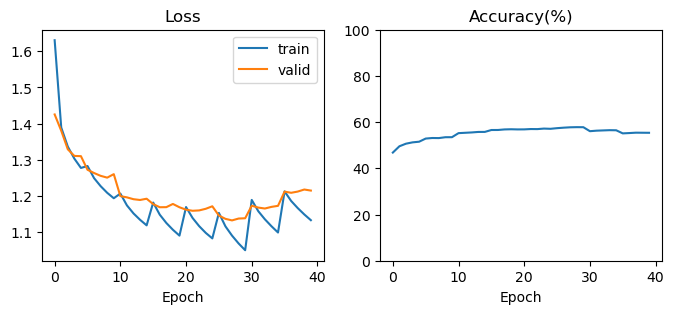

In [12]:
# 学習曲線
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(train_loss_list,label='train')
plt.plot(valid_loss_list,label='valid')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(acc_list)
plt.xlabel('Epoch')
plt.title('Accuracy(%)')
plt.ylim(0,100)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

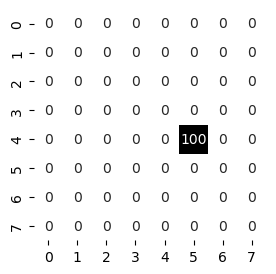

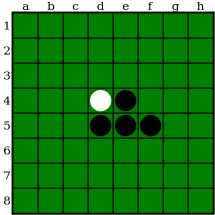

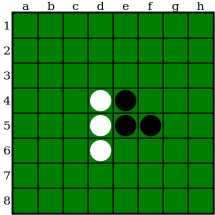

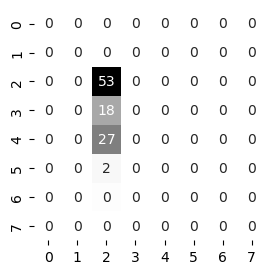

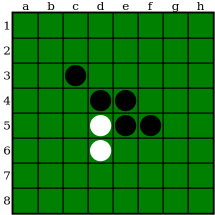

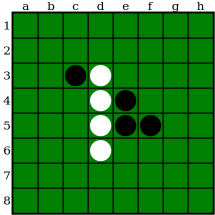

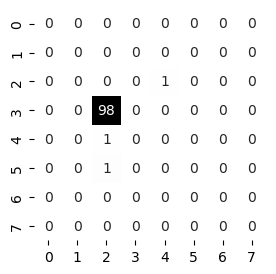

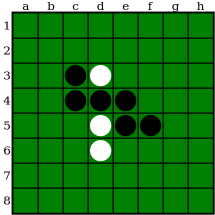

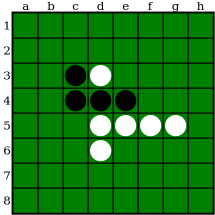

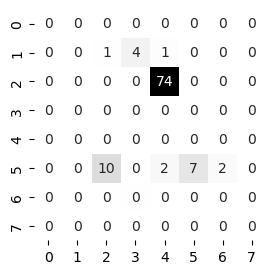

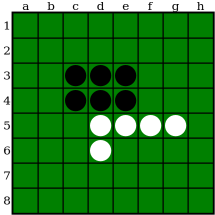

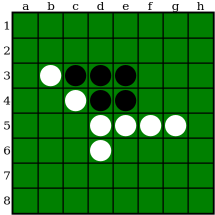

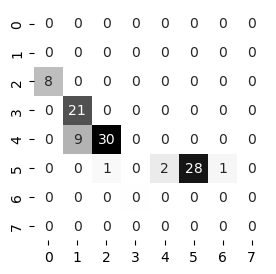

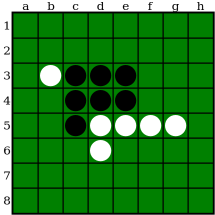

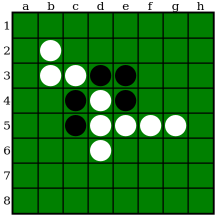

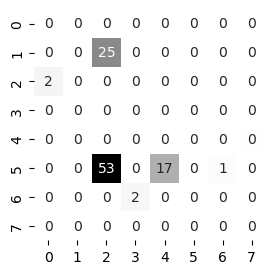

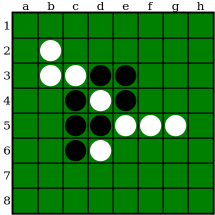

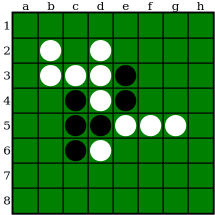

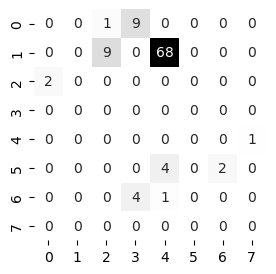

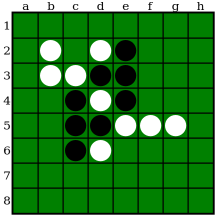

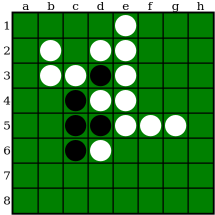

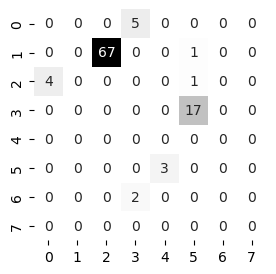

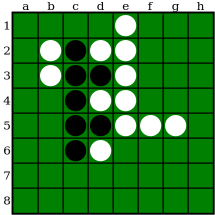

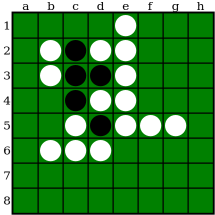

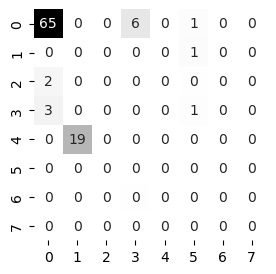

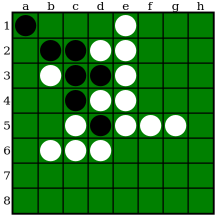

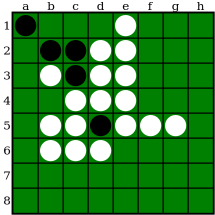

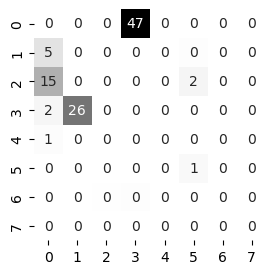

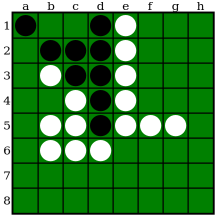

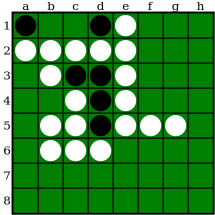

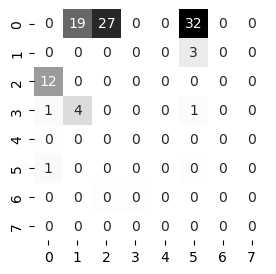

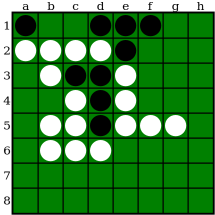

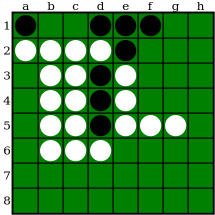

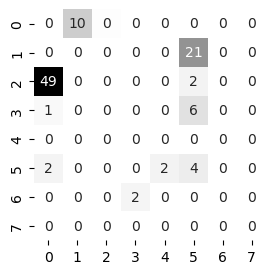

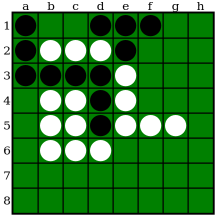

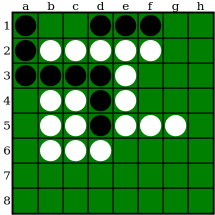

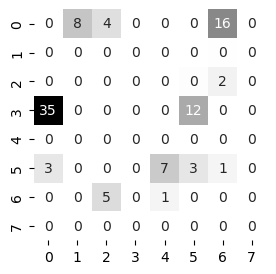

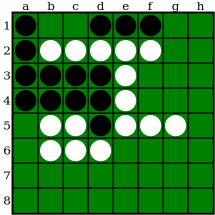

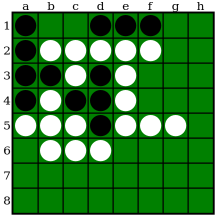

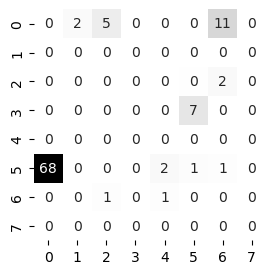

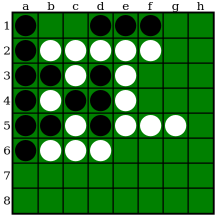

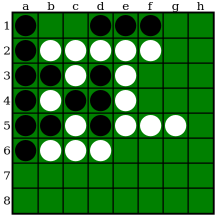

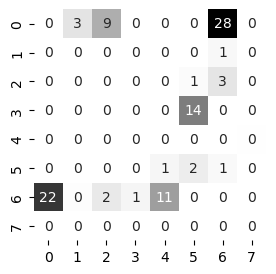

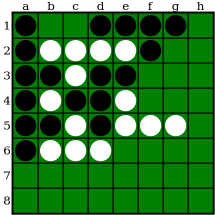

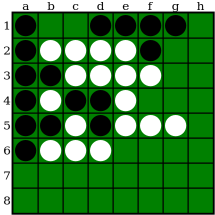

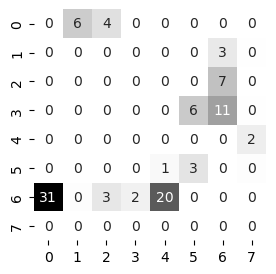

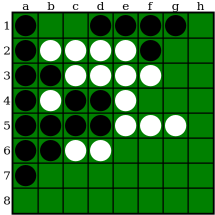

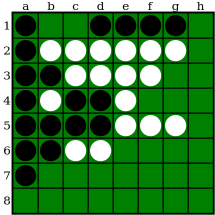

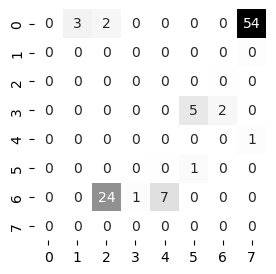

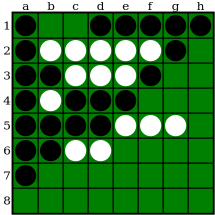

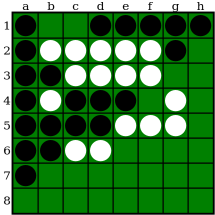

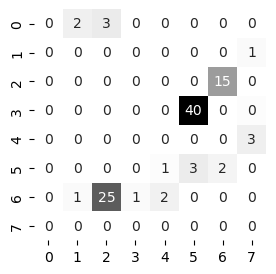

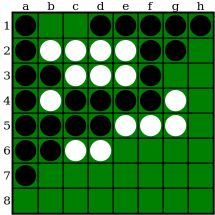

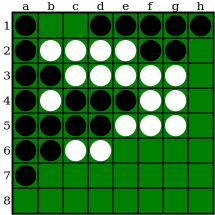

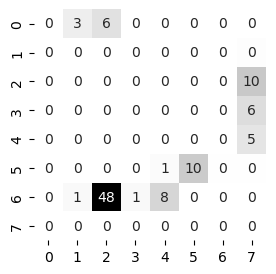

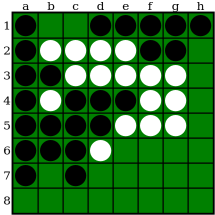

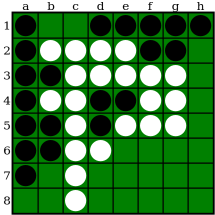

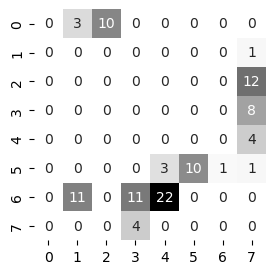

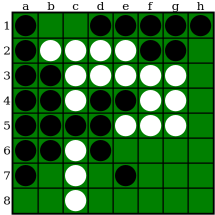

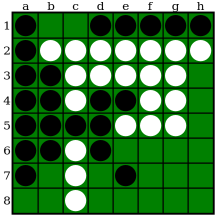

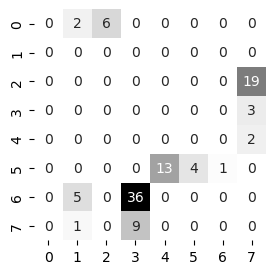

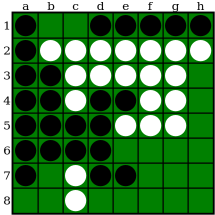

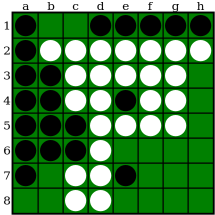

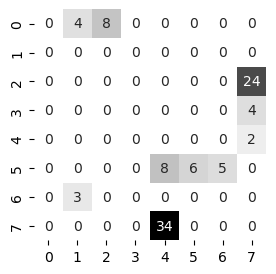

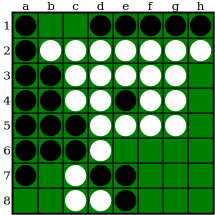

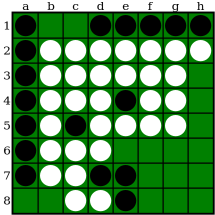

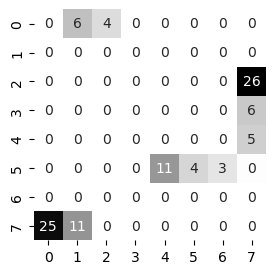

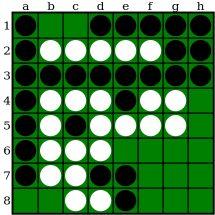

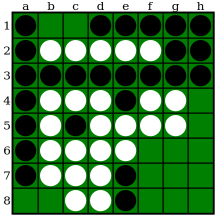

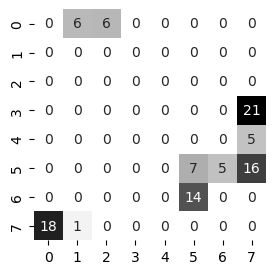

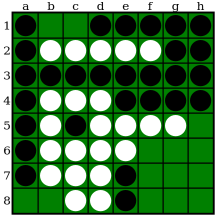

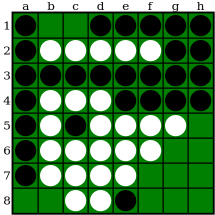

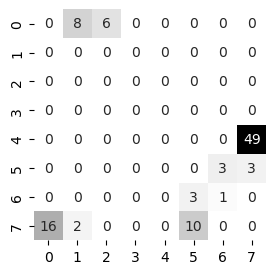

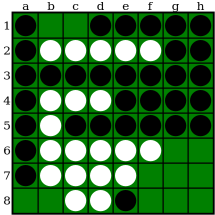

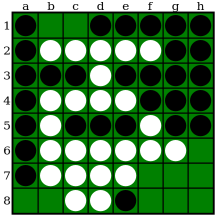

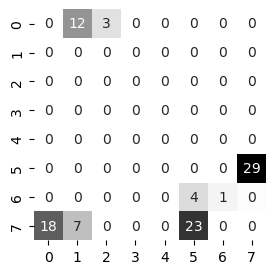

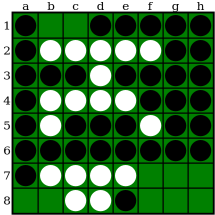

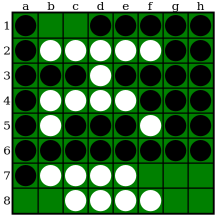

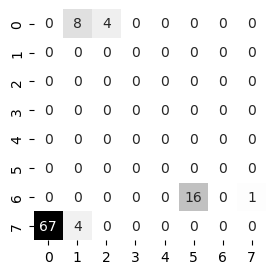

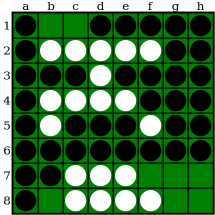

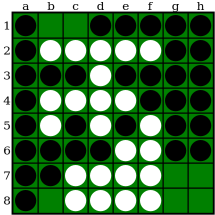

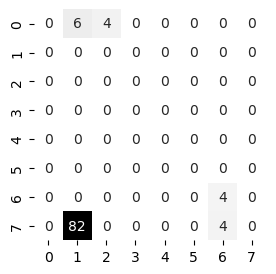

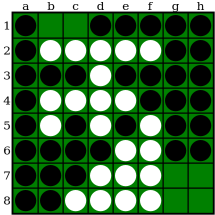

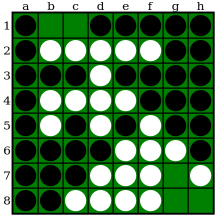

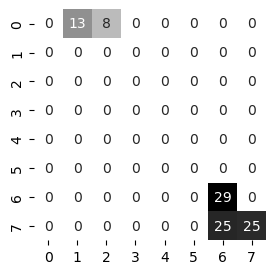

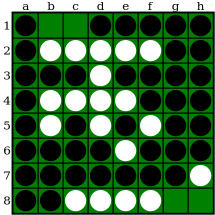

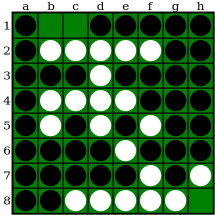

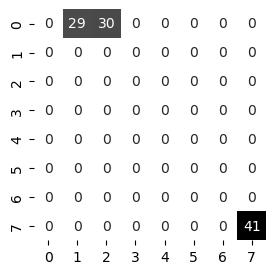

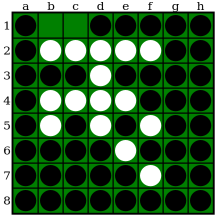

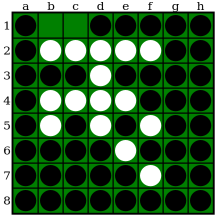

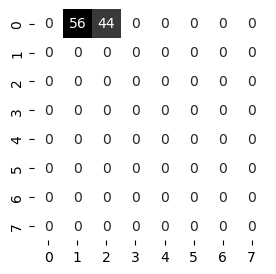

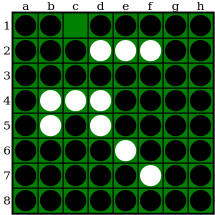

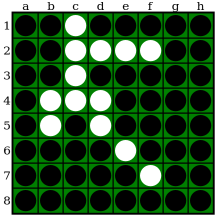

In [13]:
# 学習成果
n_trial = 1000
softmax = nn.Softmax(dim=1)
results = []

for trial in tqdm(range(n_trial)):
    board = Board()
    while not board.is_game_over():
        if board.turn:
            p = model(torch.from_numpy(board_to_array(board))).detach()
            move = p.argmax().item()
            if trial == 0:
                plt.figure(figsize=(3,3))
                p = softmax(p).numpy().reshape(8,8) *100
                sns.heatmap(p, cmap='gray_r',annot=True, fmt='.0f',cbar=False)
                plt.show()
        else:
            move = np.random.choice(list(board.legal_moves))
        board.move(move)
        if trial == 0:
            display(board)
    diff = board.diff_num()
    if board.turn:
        results.append(diff)
    else:
        results.append(-diff)

95.6%


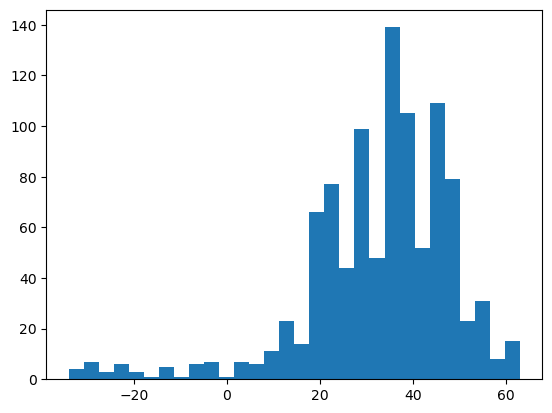

In [14]:
print(f'{np.where(np.array(results)>0,1,0).sum()/n_trial *100}%')
plt.hist(results,bins=30)
plt.show()